# Finetuned Model
This file contains the code to finetune the `Salesforce/codet5p-220m` model. Evaluation will be done further down.

In [1]:
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig
from utils import load_tokenize_data, get_compute_metrics_fn, get_comparison_values

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = 'Salesforce/codet5p-220m'
# MODEL = 'saved_models/codet5p-tuned/final_checkpoint'
DATA_SIZE = -1
SAVE_PATH = 'saved_models/codet5p-test'
MAX_LENGTH = 250

## Load Model and Data

In [3]:
# Load model from `args.load`
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m', model_max_length=MAX_LENGTH) # always use the tokenizer from codet5p-220m
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL, trust_remote_code=True)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.decoder_end_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
print(f"  ==> Loaded model from {MODEL}, model size {model.num_parameters()}")

# load dataset
data = load_tokenize_data(tokenizer, max_source_len=MAX_LENGTH, max_target_len=MAX_LENGTH, overwrite=True)

if DATA_SIZE != -1:
    data['train'] = data['train'].select([i for i in range(DATA_SIZE)])
    data['test'] = data['test'].select([i for i in range(DATA_SIZE)])

compute_metrics = get_compute_metrics_fn(tokenizer)
print('  ==> Loaded metrics fn')

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  ==> Loaded model from Salesforce/codet5p-220m, model size 222882048


Map (num_proc=64): 100%|██████████| 1000/1000 [00:06<00:00, 151.47 examples/s]


  ==> Loaded 3 datasets


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 25430.50 examples/s]


  ==> Saved to ./cache_data/code2code
  ==> Loaded metrics fn


## Training
The `Seq2SeqTrainingArguments` contain the configuration while the `trainer.train()` method starts the training process. With the default configuration one epoch takes rufley around 6-10 minutes on a Nvidia RTX 4060 (16GB).

In [4]:
training_args = Seq2SeqTrainingArguments(
    report_to='tensorboard',
    output_dir=SAVE_PATH,
    overwrite_output_dir=False,

    do_train=True,
    save_strategy='epoch',

    evaluation_strategy='epoch',
    predict_with_generate=True,
    # generation_max_length=MAX_LENGTH,
    generation_config=GenerationConfig(
        max_length=MAX_LENGTH,
        # min_length=.5 * MAX_LENGTH,
        bos_token_id = tokenizer.bos_token_id,
        eos_token_id = tokenizer.eos_token_id,
        pad_token_id = tokenizer.pad_token_id
    ),

    num_train_epochs=10,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,

    learning_rate=5e-5,
    weight_decay=0.05,
    warmup_steps=200,

    logging_dir=SAVE_PATH,
    logging_first_step=True,
    logging_steps=10,
    save_total_limit=1,

    dataloader_drop_last=True,
    dataloader_num_workers=4,

    local_rank=-1,
    deepspeed=None,
    fp16=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    compute_metrics=compute_metrics,
    eval_dataset=data['validation']
)

pre_evaluation = trainer.evaluate(data['validation'], max_length=MAX_LENGTH)

/home/random/miniconda3/envs/nlp/lib/python3.11/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Trainer is attempting to log a value of "{'bleu': 0.0, 'precisions': [0.5059271598149885, 0.252488475282585, 0.0026485627493162385, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.2068074918842258, 'translation_length': 371004, 'reference_length': 307426}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'codebleu': 0.1331015067574707, 'ngram_match_score': 0, 'weighted_ngram_match_score': 0, 'syntax_match_score': 0.45763695392265247, 'dataflow_match_score': 0.0747690731072304}" of type <class 'dict'> for key "eval/codebleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [5]:
# do training
trainer.train()

final_checkpoint_dir = os.path.join(SAVE_PATH, "final_checkpoint")
model.save_pretrained(final_checkpoint_dir)
print(f'  ==> Finish training and save to {final_checkpoint_dir}')

Epoch,Training Loss,Validation Loss,Bleu,Codebleu
0,0.201000,0.223703,"{'bleu': 0.9768272609302657, 'precisions': [0.9818476991885957, 0.9780708147485918, 0.9750442047205775, 0.9723717946634863], 'brevity_penalty': 1.0, 'length_ratio': 1.0058257922231693, 'translation_length': 309217, 'reference_length': 307426}","{'codebleu': 0.8191113215454422, 'ngram_match_score': 0.7393247481682177, 'weighted_ngram_match_score': 0.7426362066870654, 'syntax_match_score': 0.9160342766241627, 'dataflow_match_score': 0.8784500547023224}"
1,0.133600,0.199864,"{'bleu': 0.9793460329876235, 'precisions': [0.9837241209306248, 0.9804329251850962, 0.9777851534409095, 0.9754612624298858], 'brevity_penalty': 1.0, 'length_ratio': 1.002872235920189, 'translation_length': 308309, 'reference_length': 307426}","{'codebleu': 0.8410776779653238, 'ngram_match_score': 0.7679243443539316, 'weighted_ngram_match_score': 0.7701461275993254, 'syntax_match_score': 0.9265393715952237, 'dataflow_match_score': 0.8997008683128142}"
2,0.109900,0.173656,"{'bleu': 0.9803561274359189, 'precisions': [0.9846396947407016, 0.9813975255199041, 0.978815448967302, 0.9765901880936001], 'brevity_penalty': 1.0, 'length_ratio': 1.0025079206052838, 'translation_length': 308197, 'reference_length': 307426}","{'codebleu': 0.8509073627605492, 'ngram_match_score': 0.7756753320411394, 'weighted_ngram_match_score': 0.7840255097645632, 'syntax_match_score': 0.9333426711955298, 'dataflow_match_score': 0.9105859380409644}"
4,0.051800,0.151200,"{'bleu': 0.9824495882913985, 'precisions': [0.9860853342143364, 0.9833540421031459, 0.9811565994144541, 0.979215690103531], 'brevity_penalty': 1.0, 'length_ratio': 1.0042709465041995, 'translation_length': 308739, 'reference_length': 307426}","{'codebleu': 0.8653372794790393, 'ngram_match_score': 0.8052511072402527, 'weighted_ngram_match_score': 0.8089717177400372, 'syntax_match_score': 0.9339229526320265, 'dataflow_match_score': 0.9132033403038402}"
5,0.043200,0.158423,"{'bleu': 0.9843793577690338, 'precisions': [0.9880130707501403, 0.98527007569725, 0.9830879265049141, 0.9811595762371976], 'brevity_penalty': 1.0, 'length_ratio': 1.0024168417765575, 'translation_length': 308169, 'reference_length': 307426}","{'codebleu': 0.872078232805485, 'ngram_match_score': 0.8130997832148162, 'weighted_ngram_match_score': 0.816922008886524, 'syntax_match_score': 0.940656218265859, 'dataflow_match_score': 0.9176349208547411}"
6,0.033300,0.144851,"{'bleu': 0.9831570504391524, 'precisions': [0.9866934096677247, 0.9840193484211143, 0.9819064488190514, 0.9800215243126895], 'brevity_penalty': 1.0, 'length_ratio': 1.0022509481956634, 'translation_length': 308118, 'reference_length': 307426}","{'codebleu': 0.8694701599373755, 'ngram_match_score': 0.8085342713058019, 'weighted_ngram_match_score': 0.8164028374888063, 'syntax_match_score': 0.9365342190962617, 'dataflow_match_score': 0.9164093118586326}"
8,0.027500,0.169848,"{'bleu': 0.9847171902499349, 'precisions': [0.9881927585714472, 0.9855373512775503, 0.9834724736588479, 0.9816781246331059], 'brevity_penalty': 1.0, 'length_ratio': 1.00224444256504, 'translation_length': 308116, 'reference_length': 307426}","{'codebleu': 0.8784144225962559, 'ngram_match_score': 0.8217150228616233, 'weighted_ngram_match_score': 0.825575073896282, 'syntax_match_score': 0.9443980330460273, 'dataflow_match_score': 0.921969560581091}"
9,0.017200,0.180423,"{'bleu': 0.9843776568611965, 'precisions': [0.9878670532604253, 0.985206504720015, 0.9831360503933728, 0.9813131016861879], 'brevity_penalty': 1.0, 'length_ratio': 1.0029535563029803, 'translation_length': 308334, 'reference_length': 307426}","{'codebleu': 0.8754753473054865, 'ngram_match_score': 0.8180749736594105, 'weighted_ngram_match_score': 0.8218326633595741, 'syntax_match_score': 0.944518091274268, 'dataflow_match_score': 0.9174756609286931}"


Trainer is attempting to log a value of "{'bleu': 0.9768272609302657, 'precisions': [0.9818476991885957, 0.9780708147485918, 0.9750442047205775, 0.9723717946634863], 'brevity_penalty': 1.0, 'length_ratio': 1.0058257922231693, 'translation_length': 309217, 'reference_length': 307426}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'codebleu': 0.8191113215454422, 'ngram_match_score': 0.7393247481682177, 'weighted_ngram_match_score': 0.7426362066870654, 'syntax_match_score': 0.9160342766241627, 'dataflow_match_score': 0.8784500547023224}" of type <class 'dict'> for key "eval/codebleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'bleu': 0.9793460329876235, 'precisions': [0.9837241209306248, 0.9804329251850962, 0.9777851534409095, 0.97546126

  ==> Finish training and save to saved_models/codet5p-test/final_checkpoint


## Evaluation

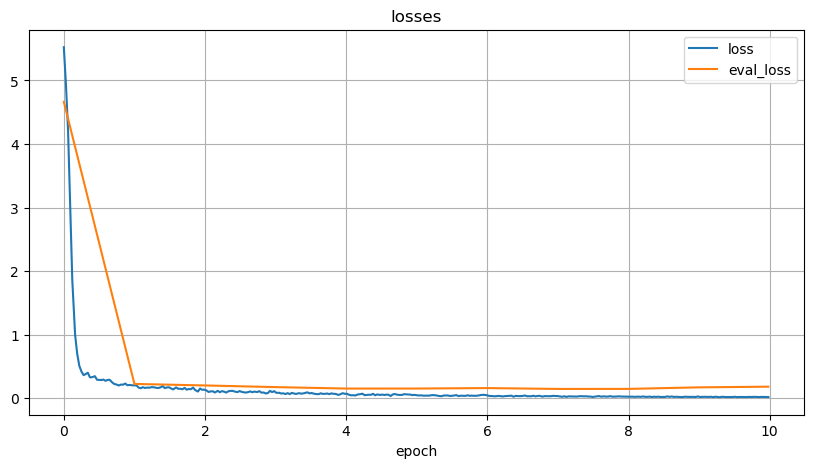

In [8]:
import matplotlib.pyplot as plt
import json

history = trainer.state.log_history
with open(SAVE_PATH + '/checkpoint-3210/trainer_state.json', 'r') as file:
    history = json.load(file)['log_history']
pre_evaluation['epoch'] = 0
history = [pre_evaluation] + history

plt.figure(figsize=(10, 5))
plt.plot([data['epoch'] for data in history if 'loss' in data], [data['loss'] for data in history if 'loss' in data], label='loss')
plt.plot([data['epoch'] for data in history if 'eval_loss' in data], [data['eval_loss'] for data in history if 'eval_loss' in data], label='eval_loss')
plt.title('losses')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '/loss.pdf')

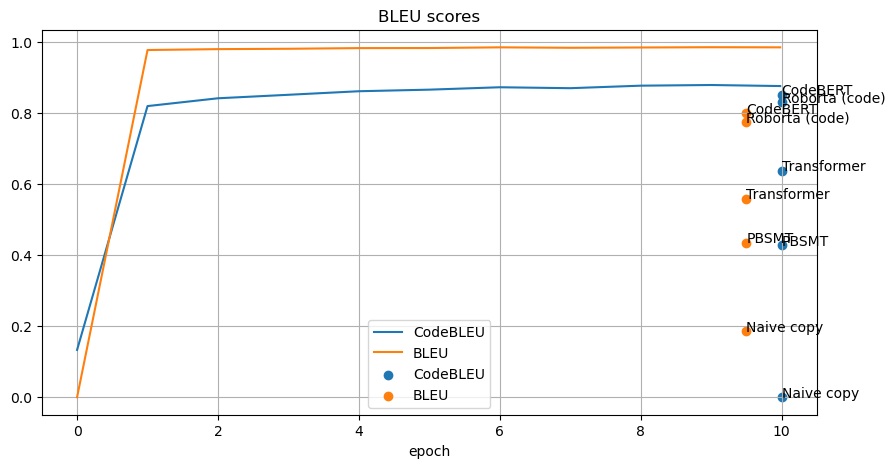

In [ ]:
eval_history = [data for data in history if 'eval_loss' in data]

plt.figure(figsize=(10, 5))

plt.plot([data['epoch'] for data in eval_history], [data['eval_codebleu']['codebleu'] for data in eval_history], label='CodeBLEU')
plt.plot([data['epoch'] for data in eval_history], [data['eval_bleu']['bleu'] for data in eval_history], label='BLEU')

c_models, c_bleus = get_comparison_values('CodeBLEU')
plt.scatter([10 for i in c_bleus], c_bleus,  label='CodeBLEU')
for i, txt in enumerate(c_models):
    plt.annotate(txt, (10, c_bleus[i]))
c_models, c_bleus = get_comparison_values('BLEU')
plt.scatter([9.5 for i in c_bleus], c_bleus,  label='BLEU')
for i, txt in enumerate(c_models):
    plt.annotate(txt, (9.5, c_bleus[i]))

plt.title('BLEU scores')
plt.xlabel('epoch')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '/bleu.pdf')

In [ ]:
from datasets import load_dataset
datasets = load_dataset("code_x_glue_cc_code_to_code_trans")
print(datasets)
print(len(max(datasets['train'], key=lambda x: len(x['java']))['java']))

In [10]:
test_input = "Translate to C#: public static void hello_world() { System.out.println(\"Hello World\"); }"
encoding = tokenizer(test_input, return_tensors="pt").to('cuda')
encoding['decoder_input_ids'] = encoding['input_ids'].clone()

outputs = model.generate(**encoding, max_length=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Translate to C#: public static void hello_world() { System.out.println("Hello World"); }public static void hello_world() { System.out.println("Hello World"); }



In [11]:
print(history[0])

{'eval_loss': 4.66406774520874, 'eval_bleu': {'bleu': 0.0, 'precisions': [0.5059271598149885, 0.252488475282585, 0.0026485627493162385, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.2068074918842258, 'translation_length': 371004, 'reference_length': 307426}, 'eval_codebleu': {'codebleu': 0.1331015067574707, 'ngram_match_score': 0, 'weighted_ngram_match_score': 0, 'syntax_match_score': 0.45763695392265247, 'dataflow_match_score': 0.0747690731072304}, 'eval_runtime': 564.6104, 'eval_samples_per_second': 0.886, 'eval_steps_per_second': 0.112, 'epoch': 0}
